In [12]:
!unzip "/content/img0002.zip" -d "/content/output/"


Archive:  /content/img0002.zip
   creating: /content/output/img0002 - Copy/img/
  inflating: /content/output/img0002 - Copy/img/slice_100.png  
   creating: /content/output/img0002 - Copy/label/
  inflating: /content/output/img0002 - Copy/label/slice_100_0.png  
  inflating: /content/output/img0002 - Copy/label/slice_100_1.png  
  inflating: /content/output/img0002 - Copy/label/slice_100_2.png  
  inflating: /content/output/img0002 - Copy/label/slice_100_3.png  
  inflating: /content/output/img0002 - Copy/label/slice_100_4.png  
  inflating: /content/output/img0002 - Copy/label/slice_100_5.png  
  inflating: /content/output/img0002 - Copy/label/slice_100_6.png  
  inflating: /content/output/img0002 - Copy/label/slice_100_7.png  
  inflating: /content/output/img0002 - Copy/label/slice_100_8.png  
  inflating: /content/output/img0002 - Copy/label/slice_100_9.png  
  inflating: /content/output/img0002 - Copy/label/slice_101_0.png  
  inflating: /content/output/img0002 - Copy/label/slice_1

In [ ]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/MartinNovotny25/VUT-FIT-KNN/blob/main/sam_baseline.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

In [2]:
using_colab = True

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

   # !mkdir images
   # !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
   # !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.2.1+cu121
Torchvision version: 0.17.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-gjf4yj72
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-gjf4yj72
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=42f1ade3db31c5a593f8831dc88d1c43accb27a445b12e077ec4398b2dceb8b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-c_x1_wmy/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2024-04-10 18:10:46--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.19, 3.

In [4]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

# Get Clicks

In [6]:
import sys
from segment_anything import sam_model_registry, SamPredictor

# SAM setup
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import distance_transform_bf

def get_random_click(ground_truth, prediction):
    prediction = prediction.astype(bool)
    ground_truth = ground_truth.astype(bool)

    prediction = prediction.astype(int)
    gt = ground_truth.astype(int)

    prediction = np.array(prediction)
    ground_truth = np.array(gt)

    D_map = ground_truth - prediction


    D_plus = D_map.copy()
    D_minus = D_map.copy()
    D_plus[D_plus < 0] = 0  # D_plus are false-negative pixels
    D_minus[D_minus > 0] = 0  # D_minus are false-positive pixels
    D_minus = np.abs(D_minus)

    # sum non zero elements of D_minus and D_plus
    sum_D_minus = np.sum(D_minus)
    sum_D_plus = np.sum(D_plus)

    click_type = 0
    if (sum_D_minus > sum_D_plus):
        click_type = 0
        selected_map = D_minus
    else:
        click_type = 1
        selected_map = D_plus

    # get distances of each pixel to the nearest border
    sel_map_transformed = distance_transform_bf(selected_map)
    # make the distances even more significant
    sel_map_exp = np.expm1(sel_map_transformed)
    # change the distances to probabilities of a given pixel being selected
    if np.sum(sel_map_exp) != 0:
        P_map = sel_map_exp / np.sum(sel_map_exp)

        # select a random pixel based on the probabilities
        flattened_probabilities = P_map.flatten()

        random_pixel_index = np.random.choice(np.arange(len(flattened_probabilities)), p=flattened_probabilities)
        random_pixel_2d_index = np.unravel_index(random_pixel_index, P_map.shape)
        return random_pixel_2d_index, click_type
    else:
        pred_white = []
        # iterate over every pixel, if it is white, add it to list
        for i in range(1,prediction.shape[0]):
            for j in range(1,prediction.shape[1]):
                if prediction[i, j] == 1:
                    pred_white.append((i, j))

        # select middle pixel
        random_pixel_2d_index = pred_white[int(len(pred_white)/2)]
        return random_pixel_2d_index, click_type

In [8]:
def calculate_iou(ground_truth, prediction):
    intersection = np.logical_and(ground_truth, prediction)
    union = np.logical_or(ground_truth, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

# SAM predict

In [22]:
import cv2
import os
import re
import string
#import get_random_click as gc
import numpy

import sys
from segment_anything import sam_model_registry, SamPredictor

import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import distance_transform_bf

from google.colab.patches import cv2_imshow

def sam_predict(input_image, ground_truth, prediction):

    # number of clicks
    num_of_clicks = 5

    # click lists
    click_list = []
    type_list = []
    all_masks = []
    all_scores = []

    click_1 = []
    click_2 = []
    click_5 = []
    click_10 = []
    click_15 = []

    masks = []
    scores = []

    # Convert grayscale images so SAM accepts them
    conv_input_image = np.expand_dims(input_image, axis=2)
    conv_input_image = np.repeat(conv_input_image, 3, axis=2)


    # # TODO: Garbage? -> SafariDrip: Garbango
    # # conv_prediction = np.expand_dims(prediction, axis=2)
    # # conv_prediction = np.repeat(conv_prediction, 3, axis=2)
    # # conv_ground_truth = np.expand_dims(ground_truth, axis=2)
    # # conv_ground_truth = np.repeat(conv_ground_truth, 3, axis=2)

    for i in range(num_of_clicks + 1):

        # Generate clicks and append them to the list
        random_pixel_2d_index, click_type = get_random_click(ground_truth, prediction)
        click_list.append([random_pixel_2d_index[1], random_pixel_2d_index[0]])
        type_list.append(click_type)

        click_list_np = np.array(click_list)
        type_list_np = np.array(type_list)

        # Set predictor to our image
        predictor.set_image(conv_input_image)

        # Generate masks, scores and logits
        # for multiple clicks, only best mask input is selected -- OPTIONAL
        if len(type_list) == 1:
            masks, scores, logits = predictor.predict(
                point_coords=click_list_np,
                point_labels=type_list_np,
            )
        else:
            mask_input = logits[np.argmax(scores), :, :]
            masks, scores, logits = predictor.predict(
                point_coords=click_list_np,
                point_labels=type_list_np,
                mask_input=mask_input[None, :, :],
                multimask_output=True
            )

        # Assign new mask
        if i == 0:
          mask_image1 = (masks[0] * 255).astype(np.uint8)  # Convert to uint8 format
          cv2.imwrite('mask_for_pred_assignment1.png', mask_image1)  # Save the mask
          prediction1 = cv2.imread('mask_for_pred_assignment1.png',
                                cv2.IMREAD_GRAYSCALE)  # Load the mask in binary format
          predictions = [prediction1]
        else:
          mask_image1 = (masks[0] * 255).astype(np.uint8)  # Convert to uint8 format
          mask_image2 = (masks[1] * 255).astype(np.uint8)
          mask_image3 = (masks[2] * 255).astype(np.uint8)

          cv2.imwrite('mask_for_pred_assignment1.png', mask_image1)  # Save the mask
          prediction1 = cv2.imread('mask_for_pred_assignment1.png',
                                cv2.IMREAD_GRAYSCALE)  # Load the mask in binary format
          cv2.imwrite('mask_for_pred_assignment2.png', mask_image2)  # Save the mask
          prediction2 = cv2.imread('mask_for_pred_assignment2.png',
                                cv2.IMREAD_GRAYSCALE)  # Load the mask in binary format
          cv2.imwrite('mask_for_pred_assignment3.png', mask_image3)  # Save the mask
          prediction3 = cv2.imread('mask_for_pred_assignment3.png',
                                cv2.IMREAD_GRAYSCALE)  # Load the mask in binary format
          predictions = [prediction1, prediction2, prediction3]

        # Calculate IoU for first returned mask
        our_scores = []
        for k in range(len(predictions)):
          our_scores.append(calculate_iou(ground_truth, predictions[k]))

        maximum = max(our_scores)
        index = 0
        for k,j in enumerate(our_scores):
          if j == max:
            index = k

        prediction = predictions[index]
        score = our_scores[index]
        if i == 1:
            click_1.append(score)
        elif i == 2:
            click_2.append(score)
        elif i == 5:
            click_5.append(score)
        elif i == 10:
            click_10.append(score)
        elif i == 15:
            click_15.append(score)

    # Clear the lists for new images
    click_list.clear()
    type_list.clear()

    return [click_1, click_2, click_5, click_10, click_15]

# Loop over images

/content/output/img0001/img/slice_100.png
['100']


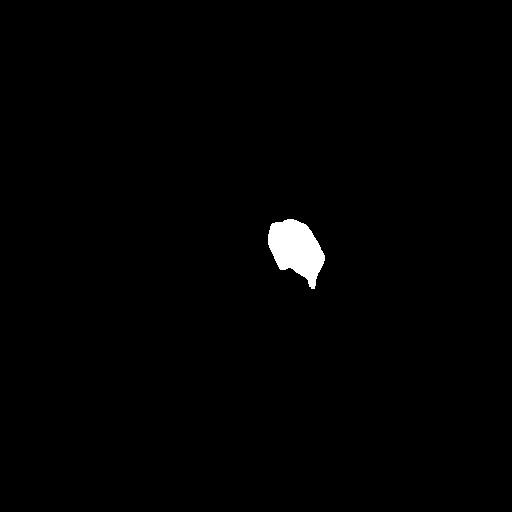

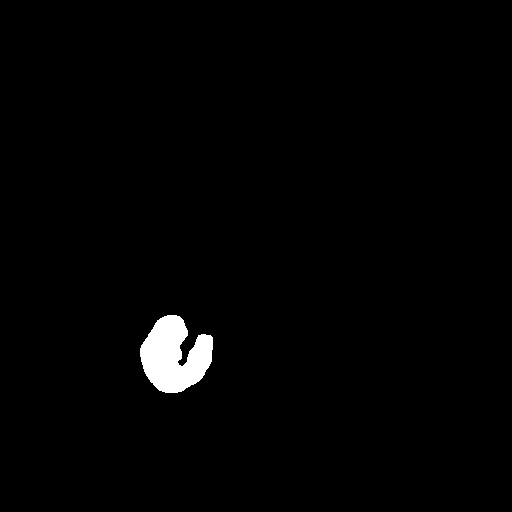

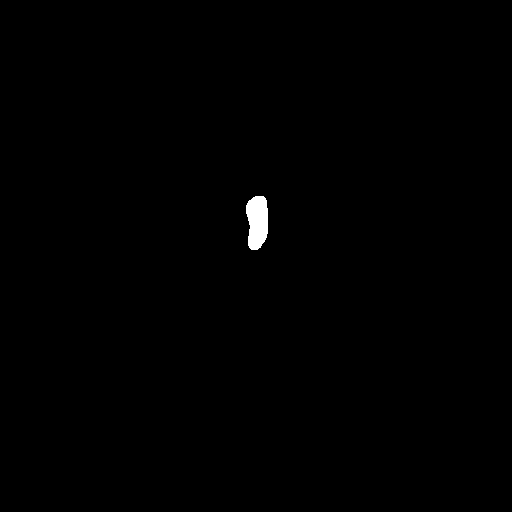

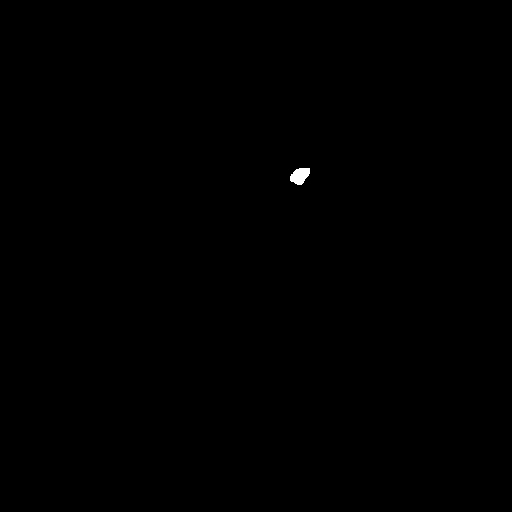

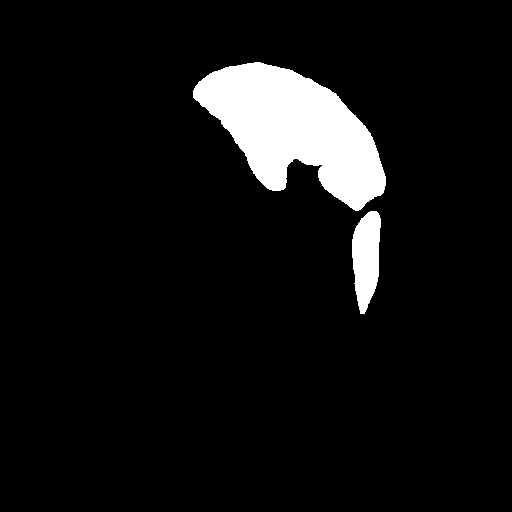

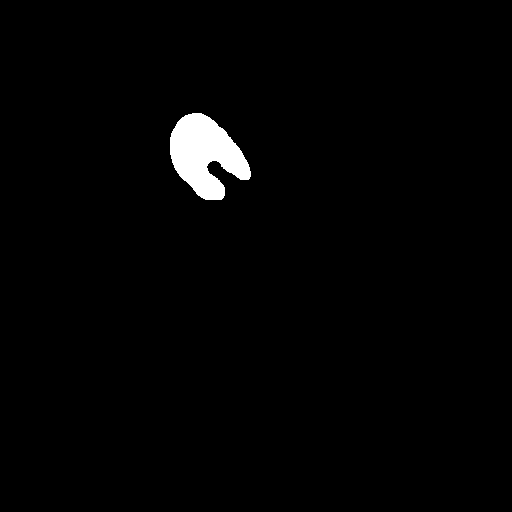

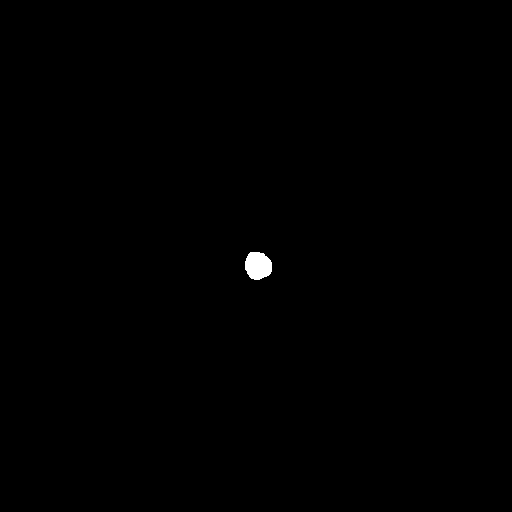

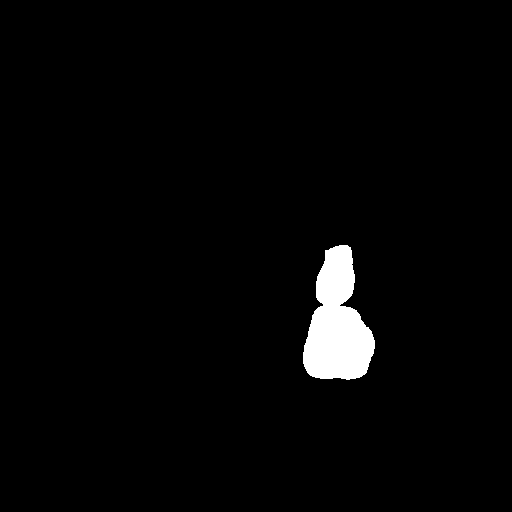

/content/output/img0001/img/.ipynb_checkpoints
/content/output/img0002/img/slice_100.png
['100']


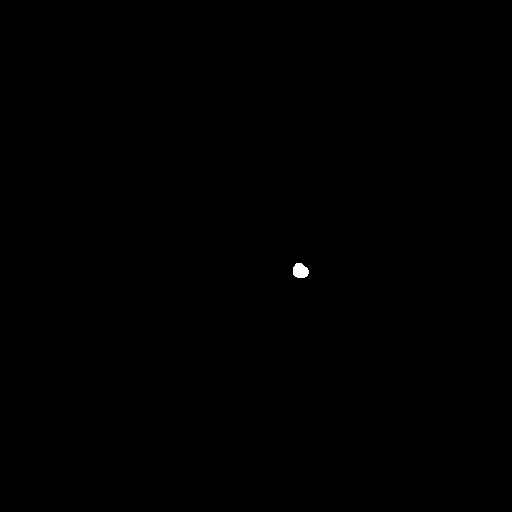

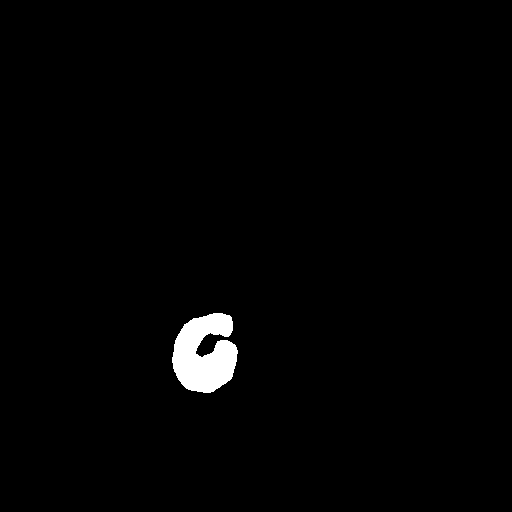

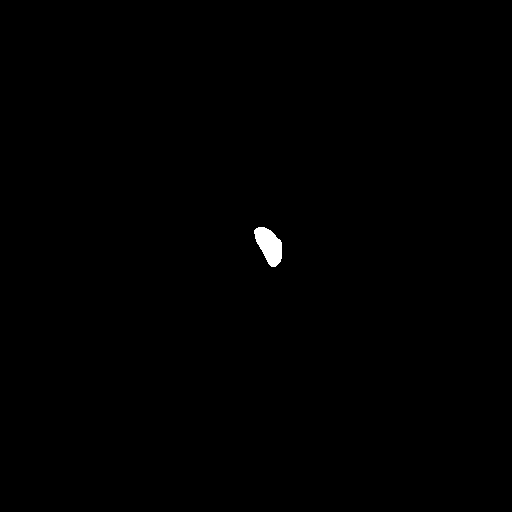

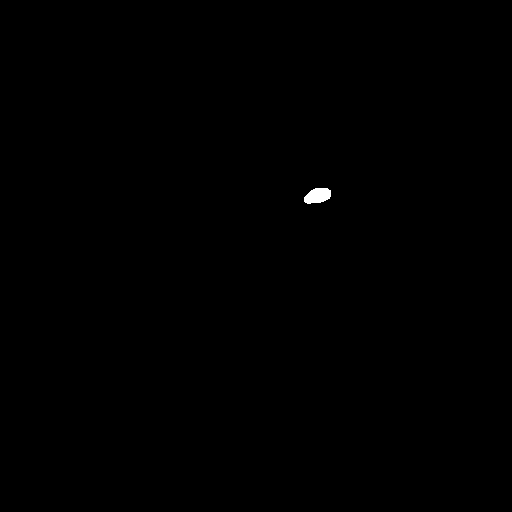

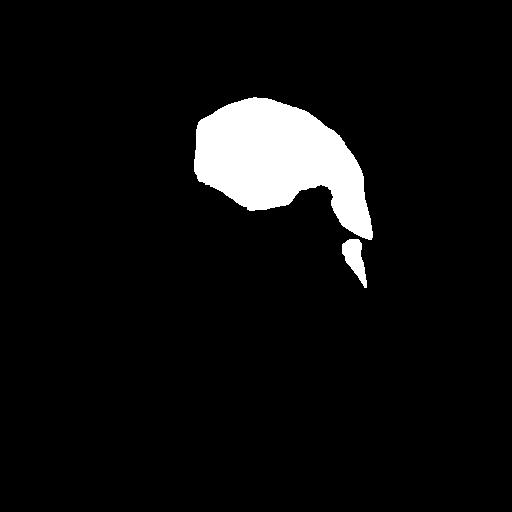

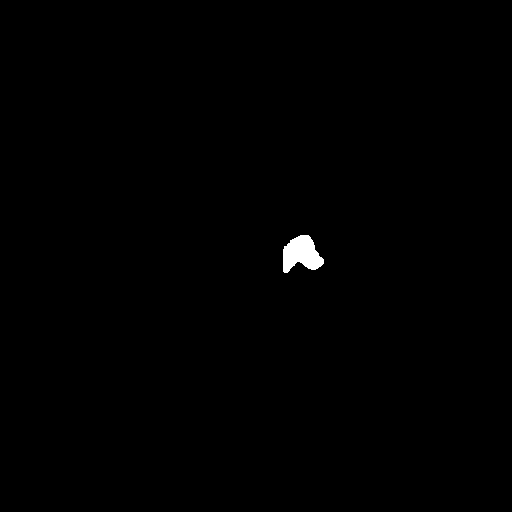

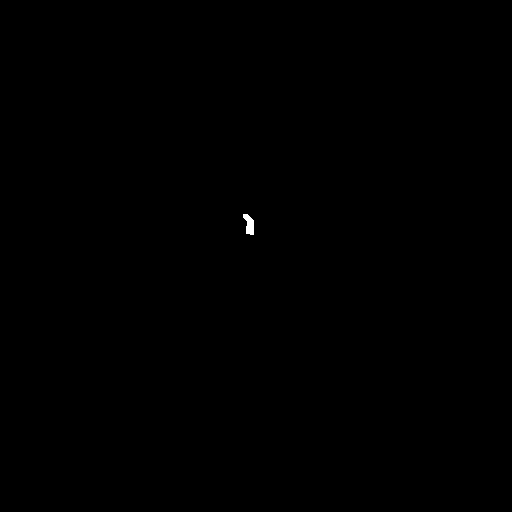

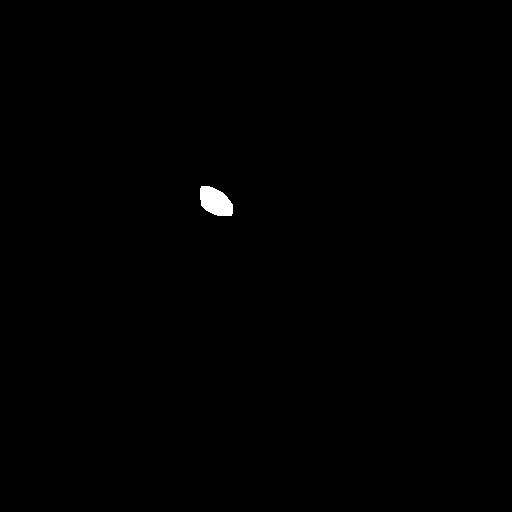

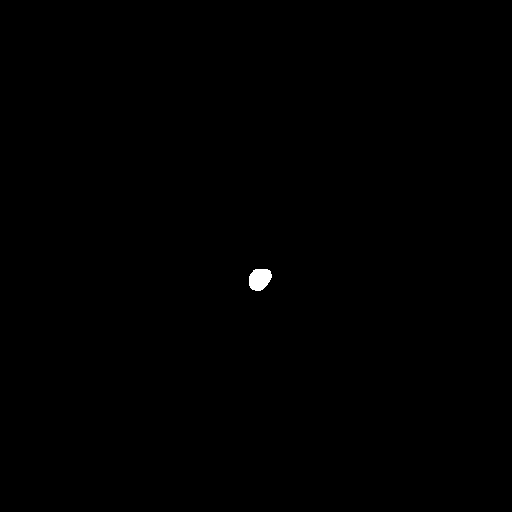

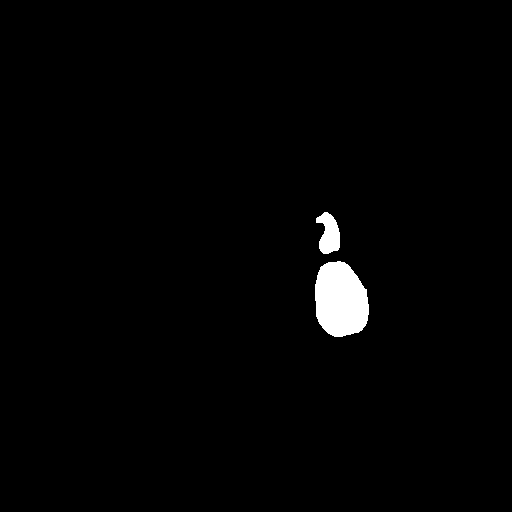

/content/output/img0002/img/slice_100.png
['100']


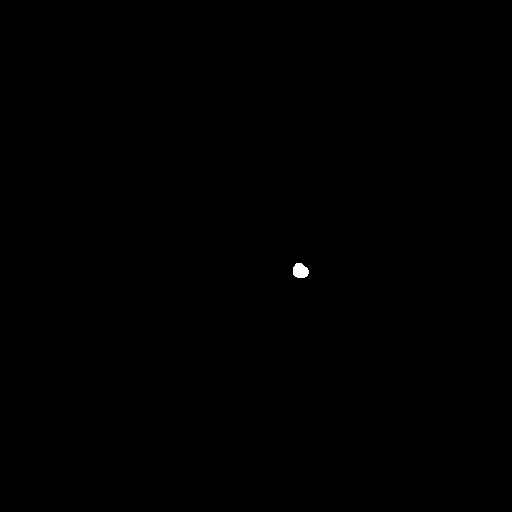

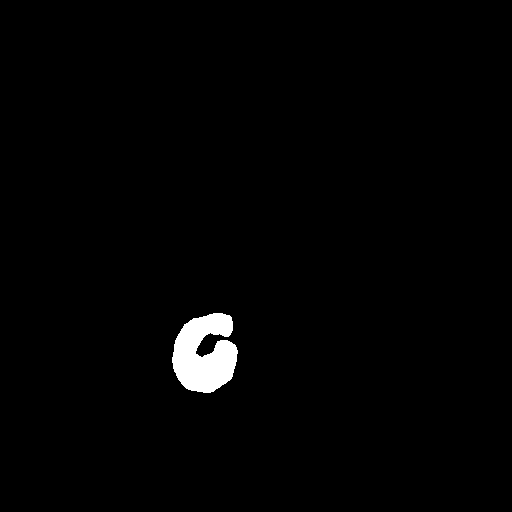

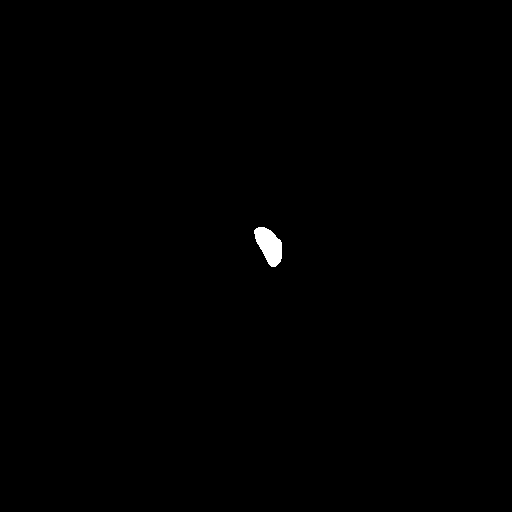

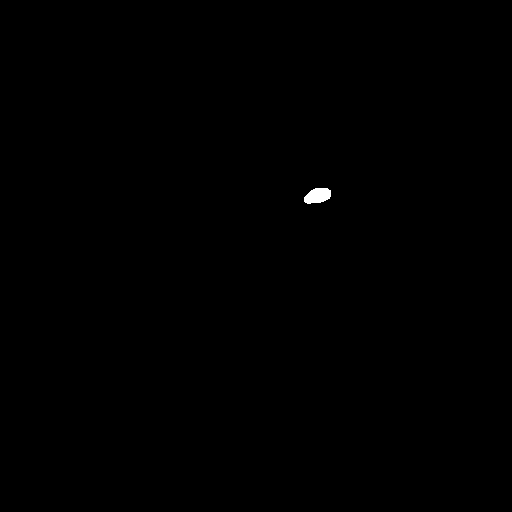

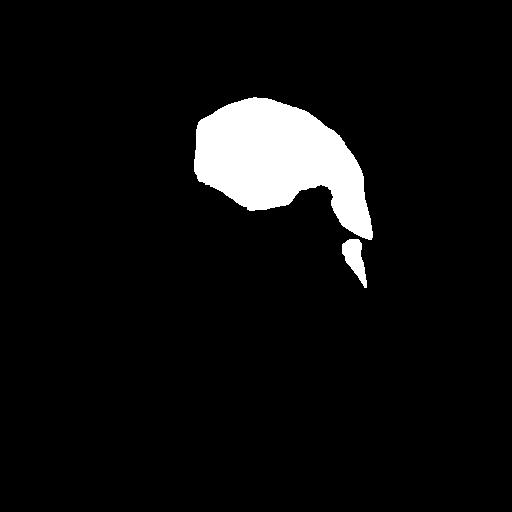

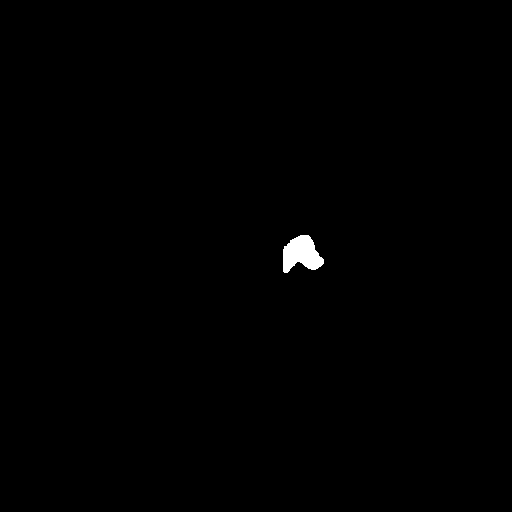

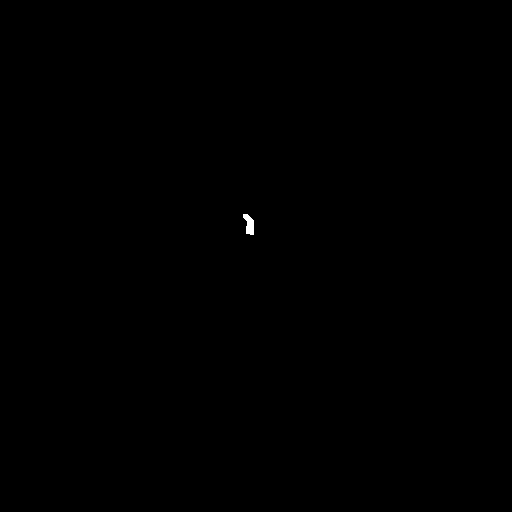

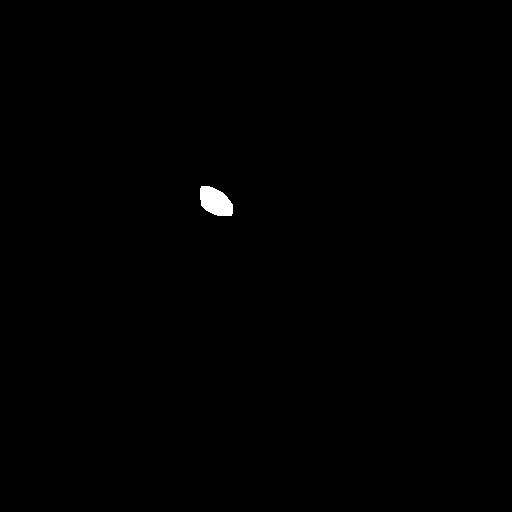

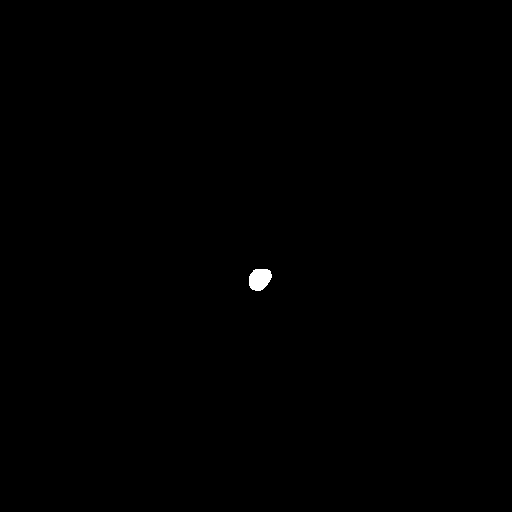

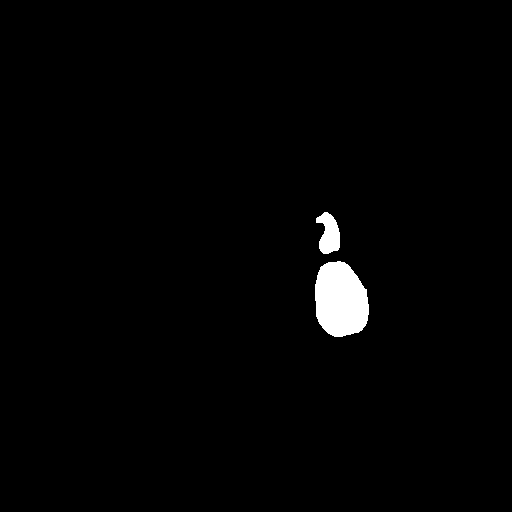

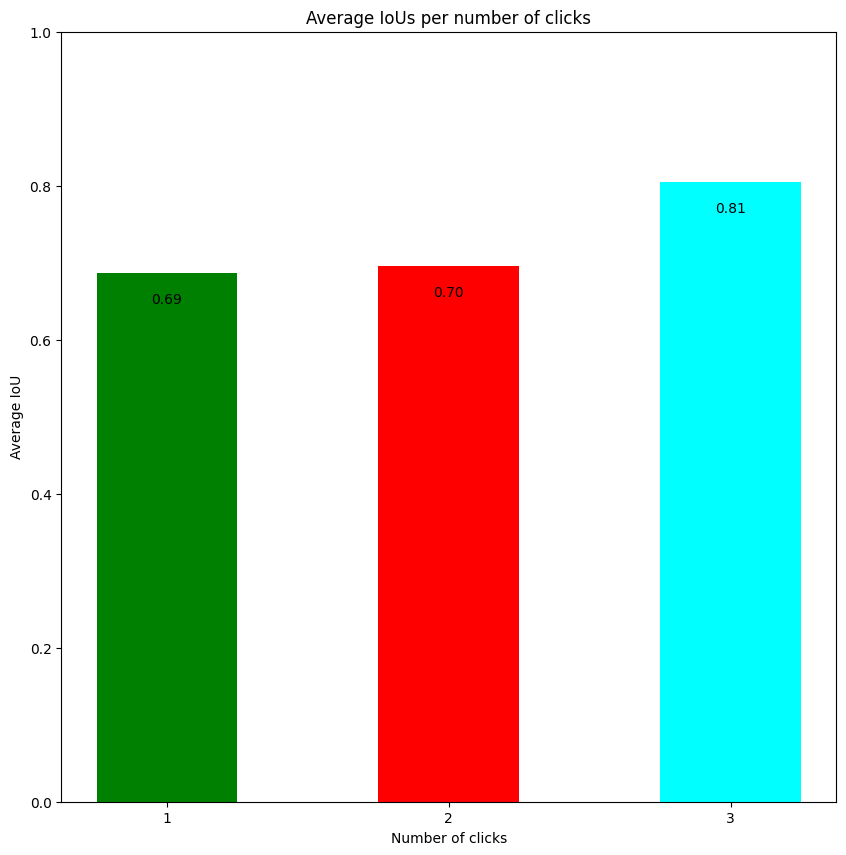

In [23]:
import cv2
import os
import re
import string
#import get_random_click as gc
#import sam_predict as sp
import numpy as np

import sys
from segment_anything import sam_model_registry, SamPredictor


# Get root directory with images
root_image_directory = os.path.abspath('output')
slice_number_regex = r'\d+'

# Lists for mask scores
dataset_click_1 = []
dataset_click_2 = []
dataset_click_5 = []
dataset_click_10 = []
dataset_click_15 = []

# Open diretory with individual image set directories - imgXXXX
for image_directory in os.listdir(root_image_directory):
    # Get full path to the directory - path/to/imgXXXX
    image_directory_filepath = os.path.join(root_image_directory, image_directory)
    # Get path to input_image directory - imgXXXX/img
    for dir in os.listdir(image_directory_filepath):
      if dir == 'img':
        input_image_directory = os.path.join(image_directory_filepath, dir)
      elif dir == 'label':
        label_image_directory = os.path.join(image_directory_filepath, dir)


    # Open directory with individual input images - imgXXXX/img/slice_XX
    for input_image in os.listdir(input_image_directory):
        # filepath to individual input images - imgXXXX/img/slice_XX.png
        input_image_filepath = os.path.join(input_image_directory, input_image)

        # Read the input image
        image = cv2.imread(input_image_filepath, cv2.IMREAD_GRAYSCALE)

        # Get slice number
        find_result = re.findall(slice_number_regex, os.path.basename(input_image_filepath))
        if (find_result == []):
          break
        else:
          print(find_result)
          slice_number = find_result[0]

        # Get input masks for current images
        for input_mask in os.listdir( label_image_directory):
            input_label_filepath = os.path.join(label_image_directory, input_mask)

            # Match slice number with correct labels for given input image
            if(re.search(slice_number, input_label_filepath)):
                ground_truth = cv2.imread(input_label_filepath, cv2.IMREAD_GRAYSCALE)
                initial_prediction = cv2.imread(input_label_filepath, cv2.IMREAD_GRAYSCALE)

                from google.colab.patches import cv2_imshow
                prediction_result = sam_predict(image, ground_truth, initial_prediction)
                #sam_predict(image, ground_truth, initial_prediction, predictor)
                dataset_click_1.append(prediction_result[0])
                dataset_click_2.append(prediction_result[1])
                dataset_click_5.append(prediction_result[2])
                dataset_click_10.append(prediction_result[3])
                dataset_click_15.append(prediction_result[4])

            else:
                continue

# Plot graph
plt.figure(figsize = (10,10))
values =  [np.average(dataset_click_1), np.average(dataset_click_2),
           np.average(dataset_click_5), np.average(dataset_click_10),
           np.average(dataset_click_15)]

labels = ['1', '2', '5', '10', '15']
colors = ['green', 'red', 'cyan', 'magenta', 'yellow']
plt.ylim(0, 1)
for i, (label, value) in enumerate(zip(labels, values)):
    plt.bar(i, value, align='center', color=colors[i], label=label, width=0.5)
    plt.text(i, value - 0.04, f'{value:.2f}', ha='center')

plt.xticks(range(len(labels)), labels)
plt.xlabel('Number of clicks')
plt.ylabel('Average IoU')
plt.title('Average IoUs per number of clicks')

# Display the plot
plt.savefig('average_iou.png')